# Instructions for Using the STAC API Extensions: query with one operator, sort, fields

This notebook provides a step-by-step guide on how to use the STAC (SpatioTemporal Asset Catalog) API to search for Sentinel-2 Level 2A data within a specified time range and geographic area. It demonstrates how to leverage STAC extensions for filtering, selecting, and sorting data based on specific parameters.

In the presented example, we will choose the Madeira Islands as the study area, focusing on the period from February 2017 to October 2017, in order to illustrate the process of drought occurrence in the region, assuming low cloud cover to ensure the visualizations are clear and readable.

In this case, we will show how to use the `query` extension to construct the appropriate parameter.

## Libraries

First, ensure all required packages are installed and imported.

In [ ]:
import pystac_client
import geogif
import stackstac
import os

* `pystac_client`, `stackstack`: A Python library for working with STAC catalogs. It enables interaction with STAC services, reading catalog information, and searching for products based on specified parameters.
* `geogif`: A Python library for creating animated GIFs from data cubes, enabling the visualization of time series data in a dynamic and engaging format.
* `os`: A standard Python package that provides functionality for interacting with the operating system, including accessing environment variables and managing file paths. It is often used for authentication and setting up access credentials for various APIs and services, such as STAC.

## S3 Credentials

In order to access the data from CloudFerro's catalog, authentication is required. To facilitate this, you will need to create an account in the Copernicus Data Space Ecosystem (CDSE). The registration process is quick and can be completed in under 60 seconds. You can find the registration link here: https://documentation.dataspace.copernicus.eu/APIs/S3.html.

Once you have created an account, the same URL will redirect you to the section where you can generate your `S3 Credentials`. To do this, simply click the `Add Credential` button. This will allow you to define an expiration date for your credentials.

After selecting the expiration date, you will have successfully created your own S3 credentials. Please make sure to save the secret key at this point, as it will not be displayed again.

Now that you have your S3 credentials, you can use them to connect to the STAC catalog. By utilizing the `os` package, you will set environment variables to authenticate yourself as a valid user for the S3 protocol.

The only variables you need to configure are:
* `CDSE_S3_ACCESS_KEY`
* `CDSE_S3_SECRET_KEY`.

In [ ]:
os.environ["CDSE_S3_ACCESS_KEY"] = "CDSE_S3_ACCESS_KEY" # Replace with your keys!
os.environ["CDSE_S3_SECRET_KEY"] = "CDSE_S3_SECRET_KEY" # Replace with your keys!

In [ ]:
os.environ["GDAL_HTTP_TCP_KEEPALIVE"] = "YES"
os.environ["AWS_S3_ENDPOINT"] = "eodata.dataspace.copernicus.eu"
os.environ["AWS_ACCESS_KEY_ID"] = os.environ.get("CDSE_S3_ACCESS_KEY")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.environ.get("CDSE_S3_SECRET_KEY")
os.environ["AWS_HTTPS"] = "YES"
os.environ["AWS_VIRTUAL_HOSTING"] = "FALSE"
os.environ["GDAL_HTTP_UNSAFESSL"] = "YES" 

## Connecting to the STAC Catalog

We connect to the Copernicus STAC catalog, available at the endpoint: https://stac.dataspace.copernicus.eu/v1.

In [12]:
URL = "https://stac.dataspace.copernicus.eu/v1"
cat = pystac_client.Client.open(URL)
cat.add_conforms_to("ITEM_SEARCH")

## Defining the Area of Interest (AOI)

We define the area as a polygon based on geographical coordinates in GeoJSON format.
* `type`: Geometry type, in this case, a polygon.
* `coordinates`: A list of coordinates defining the area.

In [47]:
geom = {
    "type": "Polygon",
    "coordinates": [
        [
            [32.6, -17.3],
            [32.6, -17.1],
            [33.0, -17.1],
            [33.0, -17.3],
            [32.6, -17.3],
        ]
    ],
}

## Defining Search Parameters

In this section, we define and combine parameters into a single dictionary for passing to the search function:
* `max_items`: The maximum number of results to retrieve.
* `collections`: The STAC collection (e.g., Sentinel-2 Level 2A data).
* `datetime`: Time range in YYYY-MM-DD/YYYY-MM-DD format.
* `intersects`: The previously defined area of interest.
* `query`: Typically a key-value pair where the key represents a specific property (e.g., eo:cloud_cover), and the value is the condition or comparison being applied.
* `sortby`: Sorts results (e.g., by the eo:cloud_cover property in ascending order).
* `fields`: Specifies which fields to exclude (e.g., geometry).

In [ ]:
params = {
    "max_items": 100,
    "collections": "sentinel-2-l2a",
    "datetime": "2017-02-01/2017-10-01",
    "intersects": geom,
    "query": {"eo:cloud_cover": {"gte": 0, "lte": 20}},
    "sortby": "properties.eo:cloud_cover",
    "fields": {"exclude": ["geometry"]},
}

## Searching the Catalog

We query the catalog and convert the results into a list of dictionaries.

In [49]:
items = list(cat.search(**params).items_as_dicts())

## Creating DataCube from STAC

After performing the search, we can create a STACK object from the obtained items. In the definition of the STACK object, the following parameters must be declared:

* `items`: The STAC items that will be included in the stack object.
* `resolution`: The desired output resolution.
* `bounds_latlon`: The spatial bounding box of the output, given in degrees of latitude and longitude.
* `chunksize`: The chunk size to be used for the Dask array.
* `epsg`: The EPSG code for the coordinate reference system to which the data will be reprojected.
* `gdal_env`: GDAL configuration options to be used when opening and reading the datasets.

In [ ]:
stack = stackstac.stack(
    items=items,
    resolution=(60, 60),
    bounds_latlon=(33.0, -17.1, 32.6, -17.3),
    chunksize=98304,
    epsg=32634,
    gdal_env=stackstac.DEFAULT_GDAL_ENV.updated(
        {
            "GDAL_NUM_THREADS": -1,
            "GDAL_HTTP_UNSAFESSL": "YES",
            "GDAL_HTTP_TCP_KEEPALIVE": "YES",
            "AWS_VIRTUAL_HOSTING": "FALSE",
            "AWS_HTTPS": "YES",
        }
    ),
)

## Band selection

In this step, we are selecting the specific spectral bands from the stacked satellite data that correspond to the Red, Green, and Blue (RGB) channels. These bands are essential for creating a true-color composite image, which represents the Earth’s surface in a way similar to how it would appear to the human eye.

The bands we select to be used to create an RGB image for visualisation, are:
* `B04_60m`: Red band
* `B03_60m`: Green band
* `B02_60m`: Blue band

In [54]:
rgb = stack.sel(band=["B04_60m", "B03_60m", "B02_60m"])

## Displaying results as a GIF

In this step, we create a GIF to visualize the filtered results. We obtain a sequence of images ordered by date in ascending order, illustrating how the drought conditions in the selected region of Madeira changed over the specified time period.

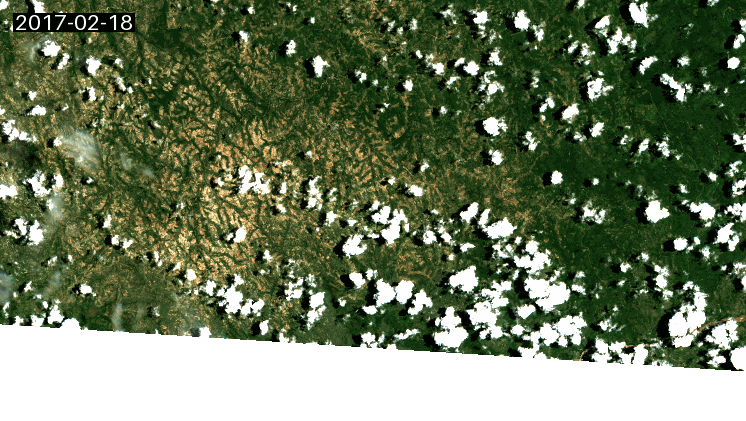

In [52]:
gif = geogif.dgif(rgb, fps=1).compute()
gif

## Displaying Cloud Cover for Results

We extract the `eo:cloud_cover` values for each item and display them. The previously used `sortby` extension allows for automatic sorting of the results based on the selected parameter, in this case, cloud cover.

In [ ]:
cloud_cover_values = [item["properties"]["eo:cloud_cover"] for item in items]
cloud_cover_values

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.01,
 0.04,
 0.04,
 0.06,
 0.08,
 0.08,
 0.17,
 0.2,
 0.2,
 0.23,
 0.24,
 0.3,
 0.32,
 0.32,
 0.33,
 0.33,
 0.34,
 0.44,
 0.54,
 0.58,
 0.59,
 0.63,
 0.76,
 0.81,
 0.92,
 0.94,
 1.25,
 1.85,
 1.92,
 1.96,
 2.1,
 2.22,
 2.27,
 2.32,
 2.43,
 2.48,
 2.7,
 3.07,
 3.1,
 3.1,
 3.42,
 3.6,
 3.78,
 4.2,
 5.27,
 5.77,
 5.82,
 6.11,
 6.12,
 6.73,
 7.04,
 7.51,
 7.72,
 7.9,
 9.5,
 9.66,
 9.96,
 12.07,
 13.01,
 13.6,
 13.78,
 14.4,
 14.86,
 15.01,
 15.04,
 15.5,
 18.04,
 18.06,
 19.27,
 19.77]